In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R')
    source('../R/utils.R')
})

In [2]:
exprs_raw <- Seurat::Read10X("/data/srlab/ik936/Foxxy/data/pbmc10x/five_prime_filtered_gene_bc_matrices_pbmc/GRCh38/") %>% as("dgCMatrix")
colnames(exprs_raw) <- paste0("fivePrime_", colnames(exprs_raw))
saveRDS(exprs_raw, '../data/figure4/fiveprime_raw.rds')

exprs_raw <- Seurat::Read10X("/data/srlab/ik936/Foxxy/data/pbmc10x/pbmc8k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/GRCh38/") %>% as("dgCMatrix")
colnames(exprs_raw) <- paste0("threepfresh_", colnames(exprs_raw))
saveRDS(exprs_raw, '../data/figure4/threepv2_raw.rds')

exprs_raw <- Seurat::Read10X("/data/srlab/ik936/Foxxy/data/pbmc10x/fastqs/pbmc6k/fastqs/PBMC_3pV1_6K/outs/filtered_gene_bc_matrices/GRCh38/") %>% as("dgCMatrix")
colnames(exprs_raw) <- paste0("threepv1_", colnames(exprs_raw))
saveRDS(exprs_raw, '../data/figure4/threepv1_raw.rds')


# Preprocessing

Load data 

In [3]:
exprs_raw <- list(
    '../data/figure4/fiveprime_raw.rds',
    '../data/figure4/threepv2_raw.rds',
    '../data/figure4/threepv1_raw.rds'
) %>% 
    lapply(readRDS) %>% 
    purrr::reduce(Matrix::cbind2)

meta_data <- fread('../data/figure4/metadata.csv')


In [4]:
head(meta_data)

cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype
<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>
threepfresh_AAACCTGAGCATCATC,threepfresh,2394,871,0.03842941,bcells,3,bnaive
threepfresh_AAACCTGAGCTAACTC,threepfresh,1694,806,0.05726092,mono,5,mono14
threepfresh_AAACCTGAGCTAGTGG,threepfresh,4520,1316,0.01946903,tcells,2,cd4mem
threepfresh_AAACCTGCACATTAGC,threepfresh,2788,898,0.01398852,tcells,1,cd4naive
threepfresh_AAACCTGCACTGTTAG,threepfresh,4667,1526,0.03621170,mono,0,mono14
threepfresh_AAACCTGCATAGTAAG,threepfresh,4440,1495,0.03806306,mono,0,mono14


The source of batch here is technology: 

- fivePrime: 10X 5-prime
- threepfresh: 10X 3-prime V2
- threepv1: 10X 3-prime V1

In [5]:
table(meta_data$donor)


  fivePrime threepfresh    threepv1 
       7697        8380        4809 

Normalize data (log CP10K)

In [6]:
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
genes_use <- genes_use[which(!grepl('^MT-', names(genes_use)))]
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% 
    normalizeData(method = 'log', 1e4)

Select variable genes

In [7]:
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$donor)
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])

PCA embedding

In [8]:
pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData() %>% 
    irlba::irlba(20)
pca_embeddings <- pca_res$v %*% diag(pca_res$d)        

UMAP embedding

In [9]:
pca_umap <- do_umap(pca_embeddings)

# Harmony

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



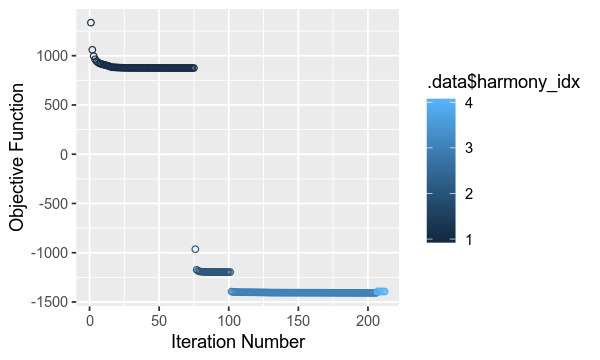

In [10]:
fig.size(3, 5)
harmony_embeddings <- HarmonyMatrix(
    pca_embeddings, 
    meta_data,
    'donor', 
    theta=1, 
    do_pca=FALSE, 
    plot_convergence=TRUE
)

In [11]:
harmony_umap <- do_umap(harmony_embeddings)

# LISI 

In [12]:
lisi_res <- rbind(
    lisi::compute_lisi(harmony_embeddings, meta_data, c('donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'harmony'),
    lisi::compute_lisi(pca_embeddings, meta_data, c('donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'pca')
) %>% 
    tidyr::gather(key, val, cell_type, donor)

In [13]:
head(lisi_res)


,type,key,val
,<chr>,<chr>,<dbl>
1,harmony,cell_type,1
2,harmony,cell_type,1
3,harmony,cell_type,1
4,harmony,cell_type,1
5,harmony,cell_type,1
6,harmony,cell_type,1


Warning message:
“Removed 13738 rows containing non-finite values (stat_density).”


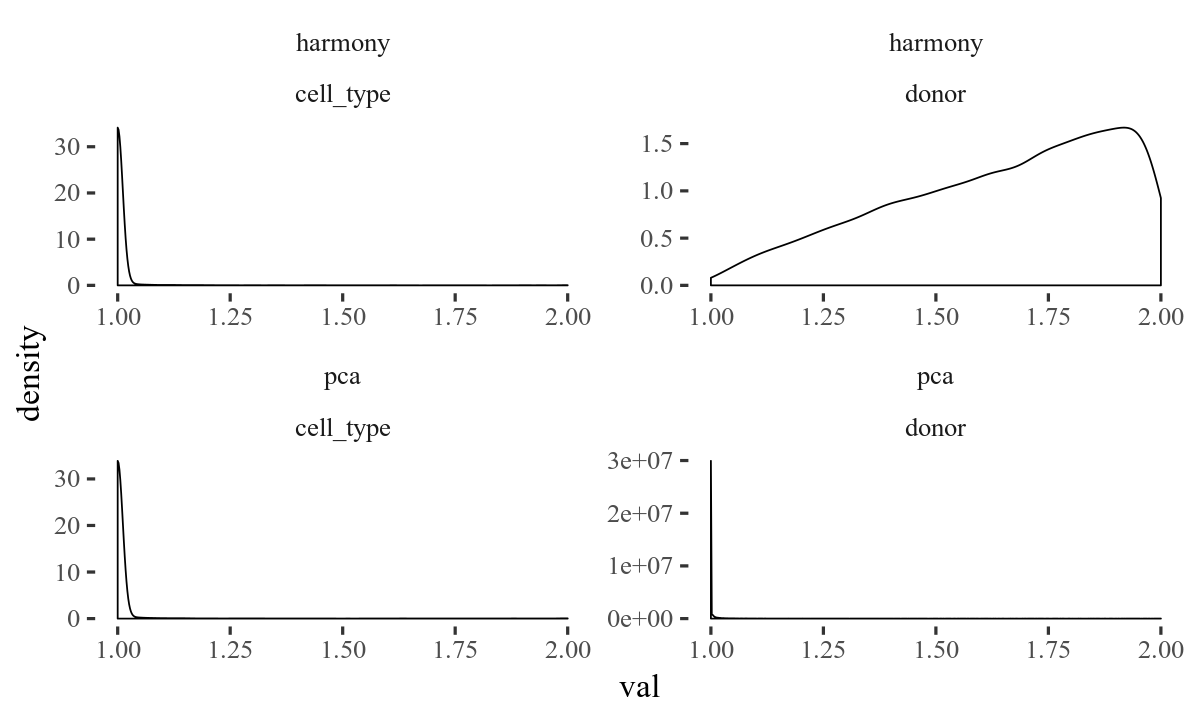

In [14]:
fig.size(6, 10)
lisi_res %>% 
    ggplot(aes(val)) + 
        geom_density() + 
        facet_wrap(~type + key, scales = 'free') + 
        theme_tufte(base_size = 20) +
        xlim(1, 2)


# Figures

In [15]:
colors_cell <- tableau_color_pal("Tableau 20")(length(union(meta_data$cell_subtype, meta_data$cell_type)))
names(colors_cell) <- union(meta_data$cell_subtype, meta_data$cell_type)
colors_donor <- toupper(c("#7fc97f", "#beaed4", "#fdc086"))
names(colors_donor) <- unique(meta_data$donor)
colors_use <- c(colors_cell, colors_donor)


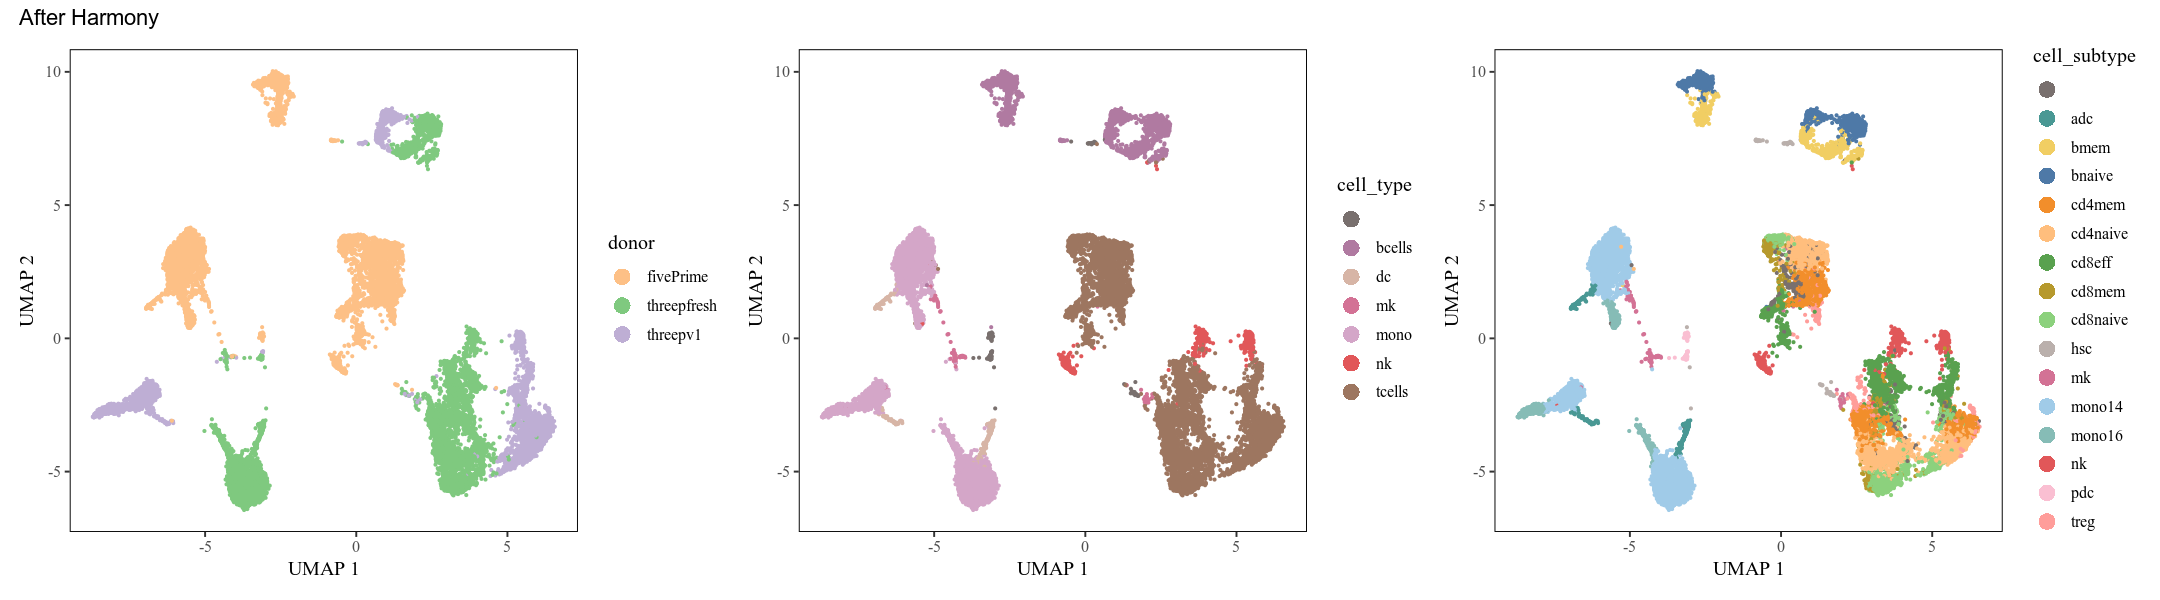

In [16]:
fig.size(5, 18)
do_scatter(pca_umap, meta_data, 'donor', palette_use = colors_use, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'cell_type', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'cell_subtype', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'After Harmony')

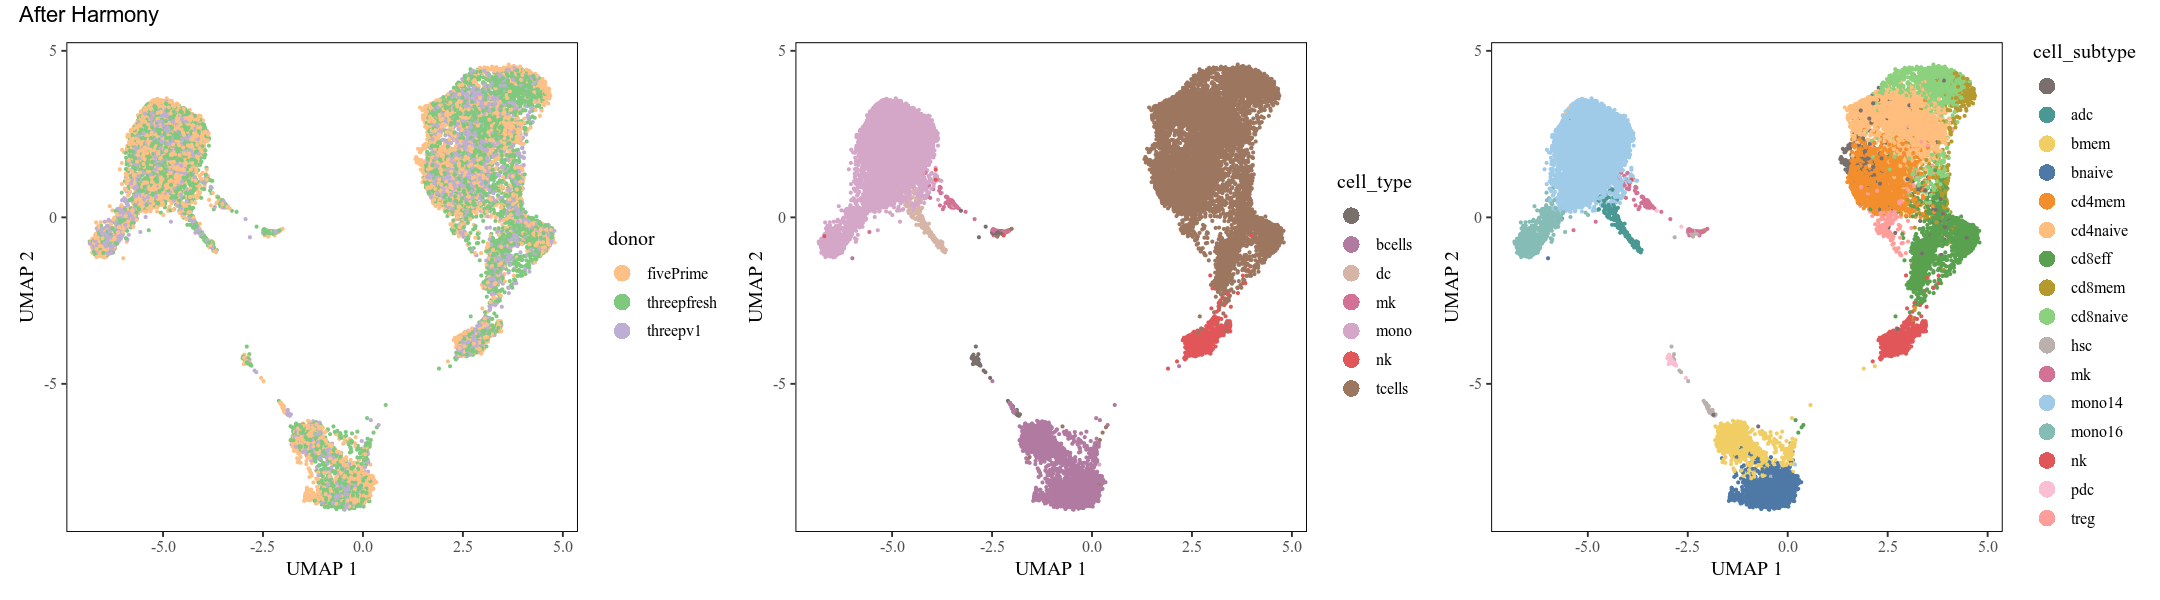

In [17]:
fig.size(5, 18)
do_scatter(harmony_umap, meta_data, 'donor', palette_use = colors_use, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'cell_type', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'cell_subtype', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'After Harmony')